# Background

This dataset, '*forestfires.csv*' was provided by P. Cortez and A. Morais at the University of Minho in 2007 for public research purposes.

The aim of the project is to predict the ***burned area*** of forest fires in the northeast region of Portugal (the Montesinho park) in 2007 by a few sets of data features available. This dataset is interesting in that the target variable is highly imbalanced. This is rather typical in any disaster-related dataset where the occurence of event is very not likely. However, it is still really important to correctly predict disasters when they are about to occur because one event can cause tremendous amount of damages.  

The project will start by performing detailed exploratory data analysis (EDA) to have a general idea about the data. While the XGBoost Regressor will be mainly used to train the model, a few different approaches will be investigated to optimize its performance against this dataset.

This dataset has been previously explored by "J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimaraes, Portugal, pp. 512-523, 2007". In there, **the authors published the best root mean squared error (RMSE) score to be 63.7**. This score will be used as a baseline reference for the model to be constructed in this project.


# Data overview


In [2]:
import numpy as np
import pandas as pd

#### Data structure

In [3]:
file_path = 'dataset/'
df = pd.read_csv(file_path +'forestfires.csv')
print('The original data has {} entries and {} features.'.format(df.shape[0],df.shape[1]))
print('')
print('First five entries of the dataset:')
df.head()

The original data has 517 entries and 13 features.

First five entries of the dataset:


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


It is a relatively small dataset with 517 entries.
#### Data type and missing values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [4]:
df.isnull().any()

X        False
Y        False
month    False
day      False
FFMC     False
DMC      False
DC       False
ISI      False
temp     False
RH       False
wind     False
rain     False
area     False
dtype: bool

Since this dataset was prepared and published for research purposes, it is already well cleaned up in general. Only `month` and `day` features are object types while all others are numerics. This dataset does not contain any missing values.

The following is the detailed information about the features provided by the data publishers:
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20 (calculated by Rain, Relative Humidity, Temperature and Wind)
6. DMC - DMC index from the FWI system: 1.1 to 291.3 (calculated by Rain, Relative Humidity and Temperature)
7. DC - DC index from the FWI system: 7.9 to 860.6 (calculated by Rain and Temperature)
8. ISI - ISI index from the FWI system: 0.0 to 56.10 (calculated by Wind)
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84


* FFMC = Fine Fuel Moisture Code: moisture content surface litter --> ignition and fire spread
* DMC = Duff Moisture Code: the moisture content of shallow organic layers --> fire intensity
* DC = Drought Code: the moisture content of deep organic layers --> fire intensity
* ISI = Initial Spread Index: fire velocity spread
* FWI = forest Fire Weather Index: combination of all of these index

Among numeric features, `X` and `Y` are discrete while all others are continuous. Even though represented by integers, `X` and `Y` are nominal categorical data and this should be properly dealth with. 

This dataset does not include **week of the month** information. Without that information, considering `day` is meaningless; interpreting "Sundays in April will have more fires than Mondays in April" does not make sense. Therefore, `day` is going to be excluded in this project. 

# EDA
Since many features, especially those index values, are derived from other low-level features, it is expected that they are highly related. If they are indeed correlated, those features may introduce undersirable redundancies.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Index correlation

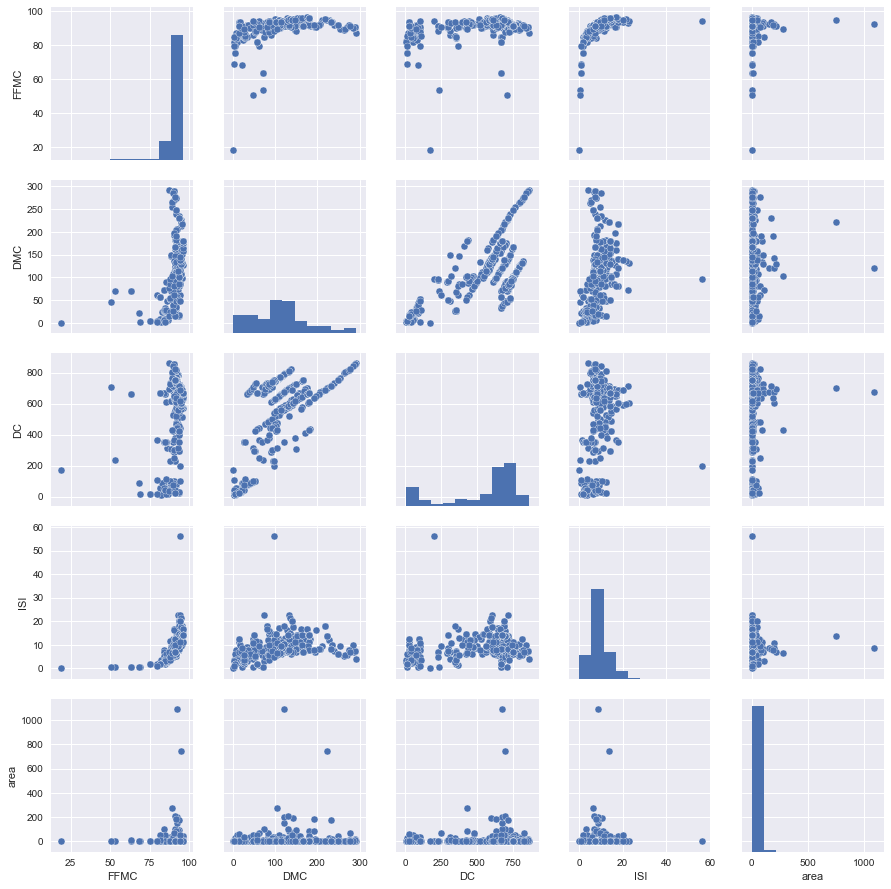

In [6]:
col_pairplot = ['FFMC', 'DMC', 'DC','ISI','area']
df_pairplot = df[col_pairplot]
plt.figure()
sns.pairplot(df_pairplot)


This pairplot shows the correlation of four index values and also their relationship with `area`. `DC` and `DMC` are positively correlated as both of them represent the moisture content. `ISI` and `FFMC` are positively skewed while `rain` is negatively skewed. The target variable, `area`, is shown to be strongly skewed ans this will be discussed in more deteil in the following sections. 
#### Low-level features correlation

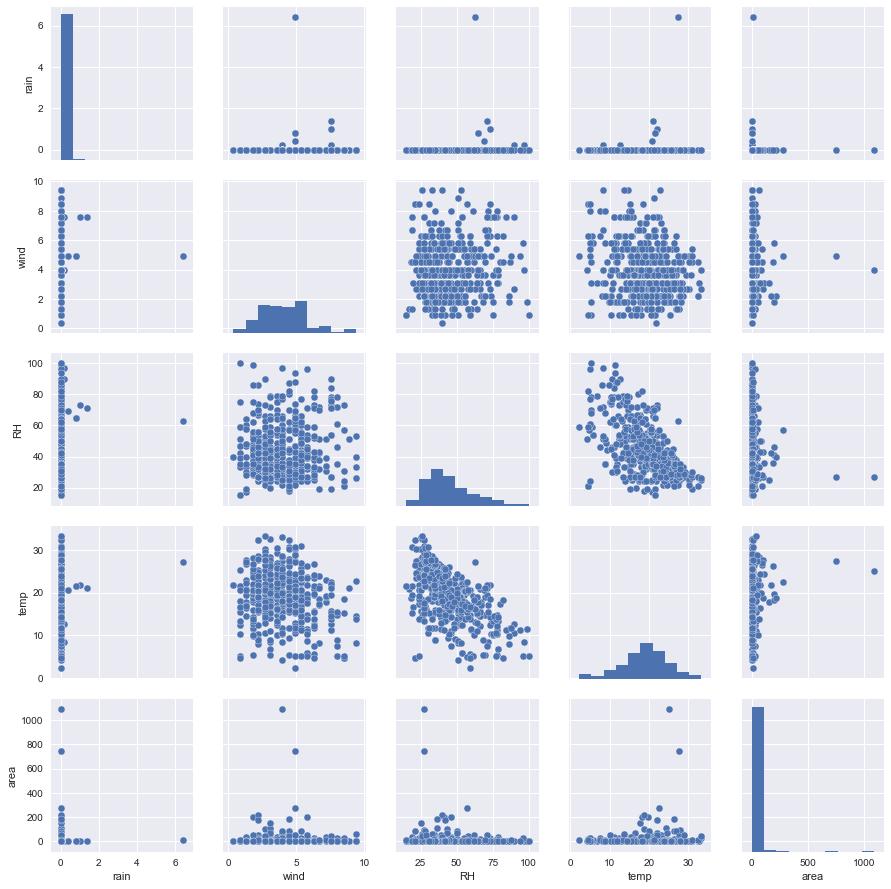

In [5]:
col_pairplot = ['rain','wind','RH','temp','area']
df_pairplot = df[col_pairplot]
plt.figure()
sns.pairplot(df_pairplot)

As expected, `temp` and `RH` are rather negatively correlated. `Rain` is shown to be strongly right-skewed as well, indicating that it barely rains in this area.

Unfortunately, the above pairplots do not reveal clear relationships between the numeric features and the target variable. This dataset also contains time varaibles that may hold interesting trends.  
#### Time series
`month` and `day` features are not ordered in this dataset. In order to have them in order, they first need to be converted to ordinal categorical types.


In [6]:
df.month = df.month.astype('category').cat.reorder_categories(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
df.day = df.day.astype('category').cat.reorder_categories(['sun','mon','tue','wed','thu','fri','sat'])

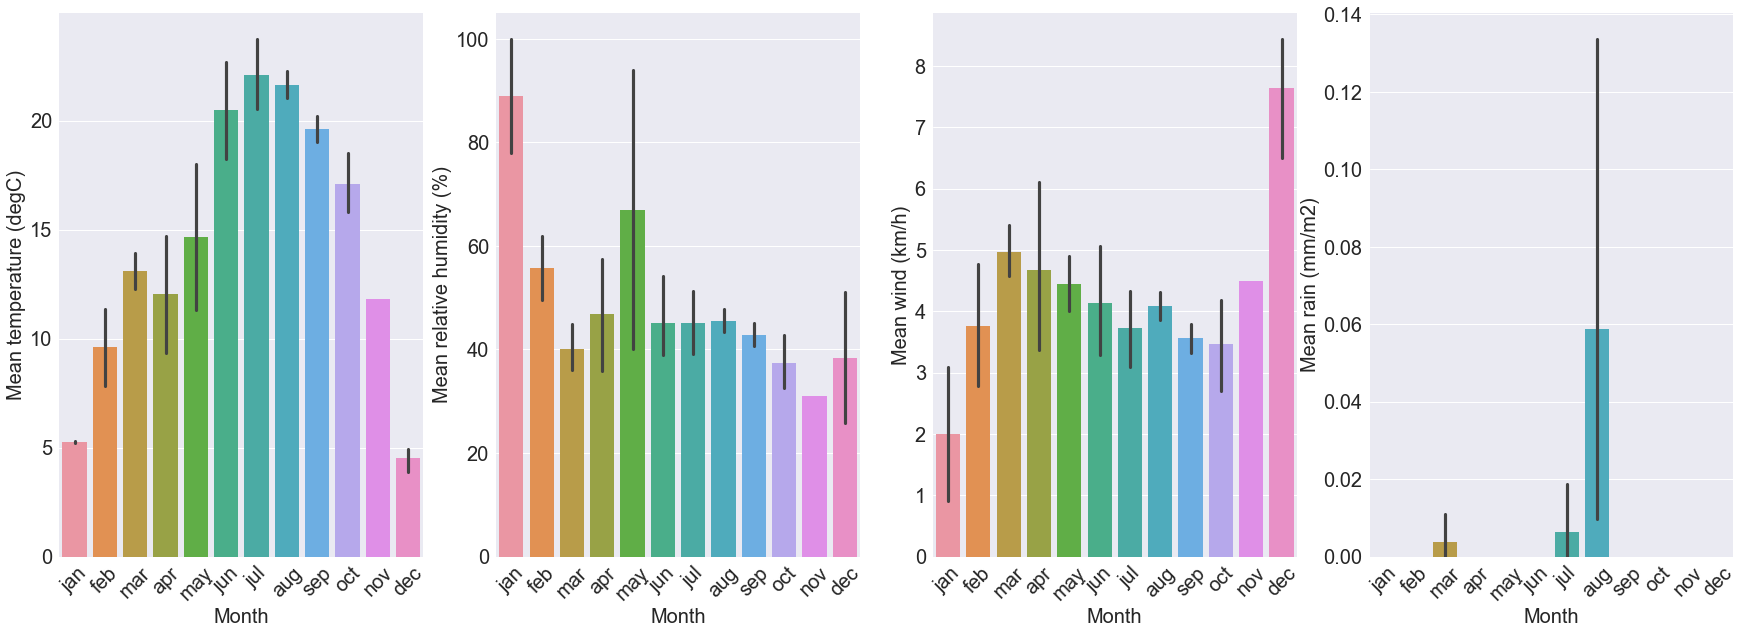

In [7]:
fontsize = 20
f, axs = plt.subplots(1,4,figsize=(30,10))
plt.subplot(141)
sns.barplot('month','temp',data=df)
plt.xticks(rotation=45,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Month',fontsize=fontsize)
plt.ylabel('Mean temperature (degC)',fontsize=fontsize)

plt.subplot(142)
sns.barplot('month','RH',data=df)
plt.xticks(rotation=45,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Month',fontsize=fontsize)
plt.ylabel('Mean relative humidity (%)',fontsize=fontsize)

plt.subplot(143)
sns.barplot('month','wind',data=df)
plt.xticks(rotation=45,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Month',fontsize=fontsize)
plt.ylabel('Mean wind (km/h)',fontsize=fontsize)

plt.subplot(144)
sns.barplot('month','rain',data=df)
plt.xticks(rotation=45,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Month',fontsize=fontsize)
plt.ylabel('Mean rain (mm/m2)',fontsize=fontsize)


These figures above describe sequential trends of the four low-level features. As expected, `temp` is high in summer and low in winter. One thing to notice is that it only rains in August.

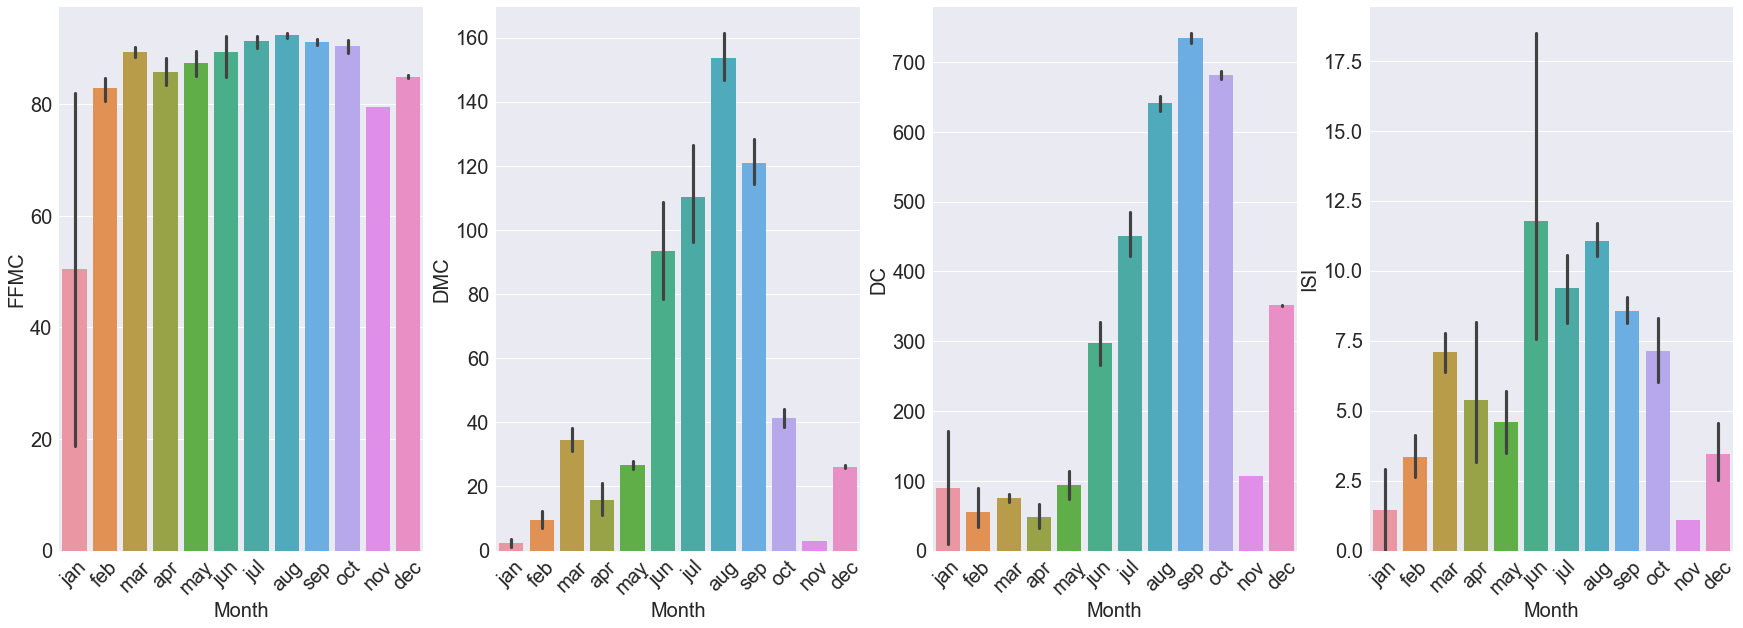

In [8]:
fontsize = 20
f, axs = plt.subplots(1,4,figsize=(30,10))
plt.subplot(141)
sns.barplot('month','FFMC',data=df)
plt.xticks(rotation=45,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Month',fontsize=fontsize)
plt.ylabel('FFMC',fontsize=fontsize)

plt.subplot(142)
sns.barplot('month','DMC',data=df)
plt.xticks(rotation=45,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Month',fontsize=fontsize)
plt.ylabel('DMC',fontsize=fontsize)

plt.subplot(143)
sns.barplot('month','DC',data=df)
plt.xticks(rotation=45,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Month',fontsize=fontsize)
plt.ylabel('DC',fontsize=fontsize)

plt.subplot(144)
sns.barplot('month','ISI',data=df)
plt.xticks(rotation=45,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Month',fontsize=fontsize)
plt.ylabel('ISI',fontsize=fontsize)

`FFMC` index is calculated by using all four low-level features. In summer, it is highly affected by `temp`, while in winter, it is affected by high `RH` and `wind`. Therefore, it is well balanced throughout the year on average. On the other hand, `DMC` and `DC` indicate that the moisture contents of shallow and deep organic layers are high around summer, making its fire intensity relatively high. `ISI` also indicates that fire spread velocity would be relatively high in summer.

The average burned area over `month` shows high degree of variance. From this figure, it is difficult to see what features may hold strong predictive power.

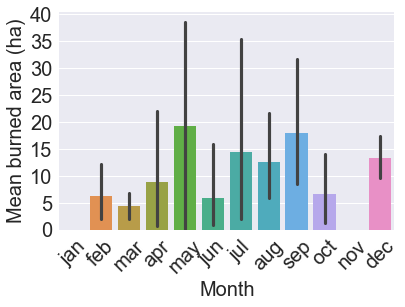

In [9]:
sns.barplot('month','area',data=df)
plt.xticks(rotation=45,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Month',fontsize=fontsize)
plt.ylabel('Mean burned area (ha)',fontsize=fontsize)

#### By locations

In [10]:
location_matrix = pd.DataFrame(0, index=np.arange(1,10), columns=np.arange(2,10)) #Y is horizontal for now
location_temp_matrix = location_matrix.copy()
location_RH_matrix = location_matrix.copy()
location_wind_matrix = location_matrix.copy()
location_rain_matrix = location_matrix.copy()

avg_by_location_df = (df.groupby(['X','Y']).mean())
for X,Y in zip(avg_by_location_df.index.get_level_values(0),avg_by_location_df.index.get_level_values(1)):
    location_temp_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'temp'])
    location_RH_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'RH'])
    location_wind_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'wind'])
    location_rain_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'rain'])
    
location_temp_matrix = location_temp_matrix.T
location_RH_matrix = location_RH_matrix.T
location_wind_matrix = location_wind_matrix.T
location_rain_matrix = location_rain_matrix.T

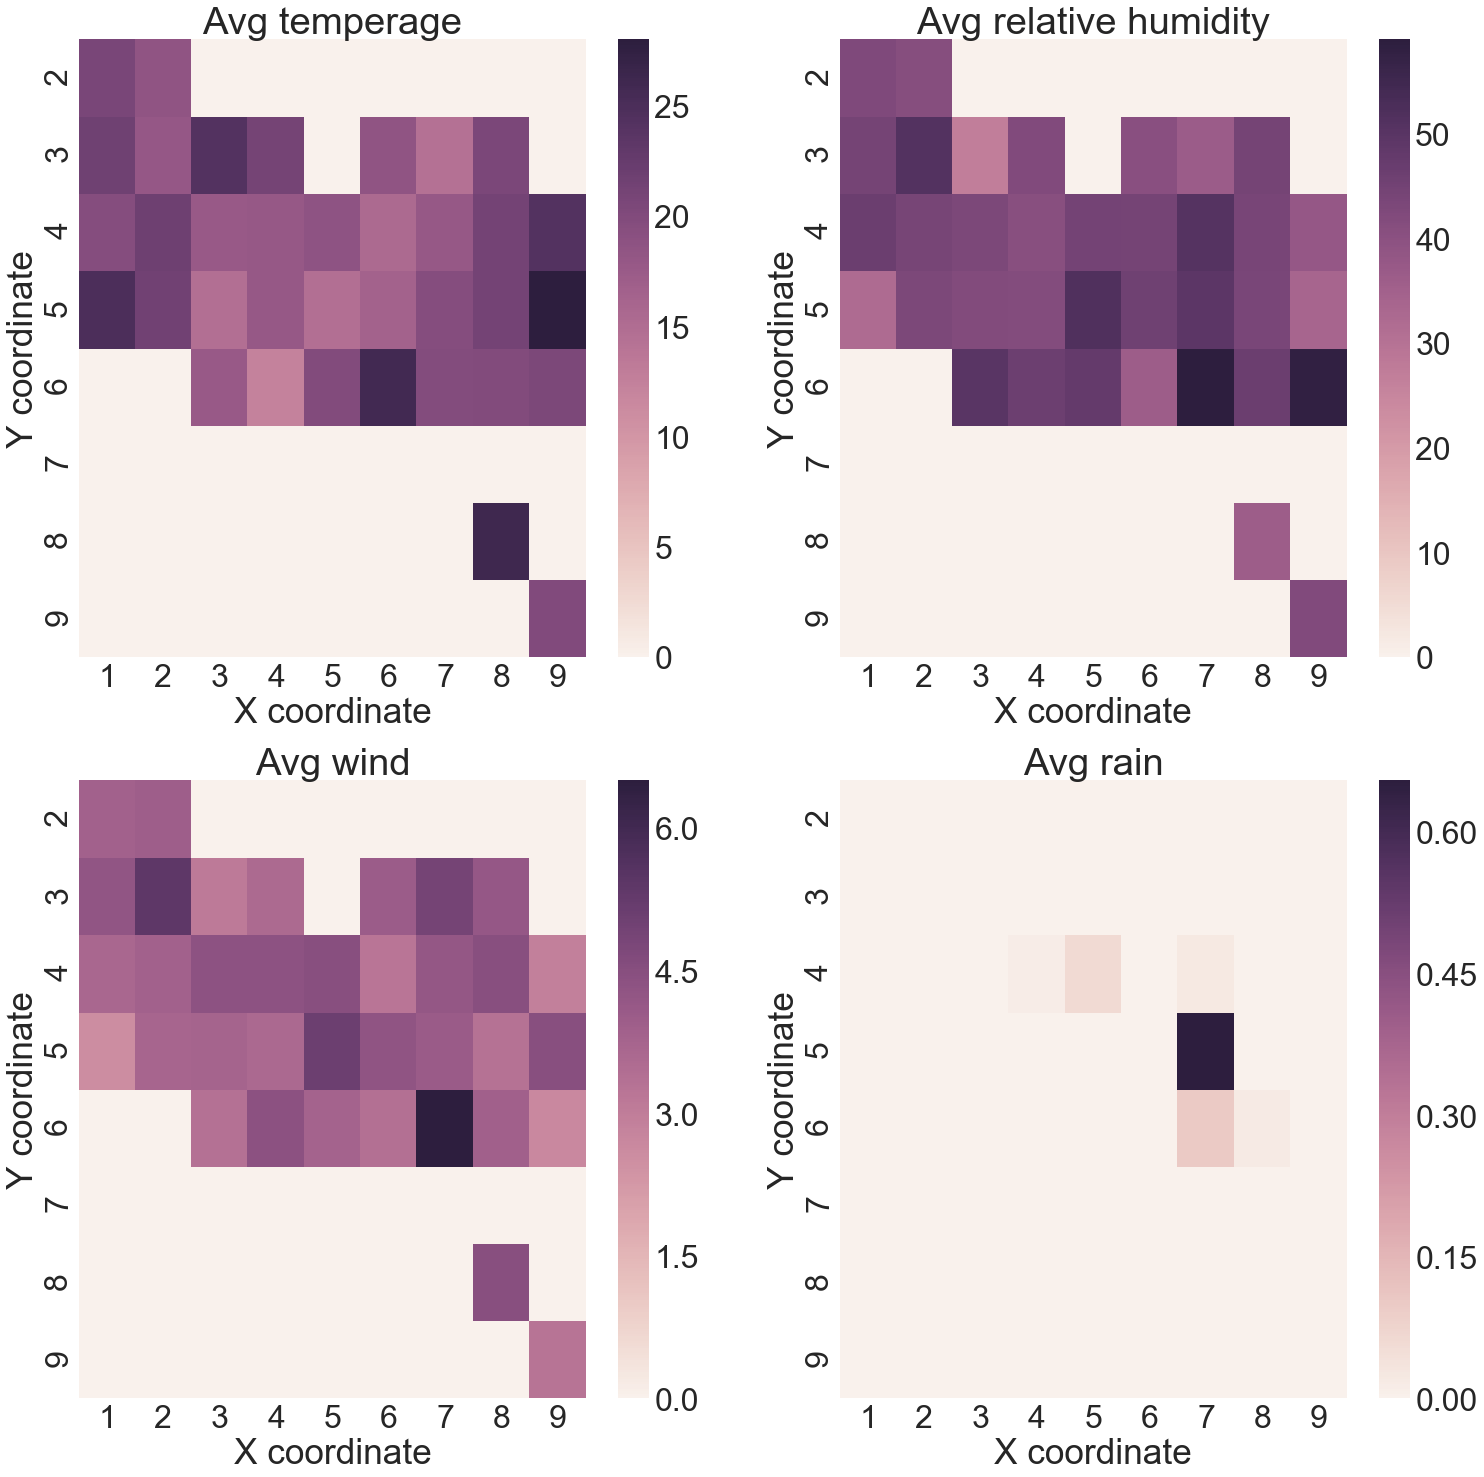

In [19]:
sns.set_context('paper',font_scale=4)
plt.figure(figsize=(25,25))
plt.subplot(221)
sns.heatmap(location_temp_matrix)
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Avg temperage')
plt.subplot(222)
sns.heatmap(location_RH_matrix)
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Avg relative humidity')
plt.subplot(223)
sns.heatmap(location_wind_matrix)
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Avg wind')
plt.subplot(224)
sns.heatmap(location_rain_matrix)
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Avg rain')

This possibly illustrates the shape of the forest in general. Or, the location where the data was not collected from (interpreted as 0 in these figures) may have negligible chance of fire. It can be seen that `rain` is highly focused to the specific area of the forest. Illustrating this information in terms of `month` would be nicer, but that is not necessary for the purpose of this project. 

This figure represents the average burned area in different locations. It is difficult to make clear assumptions what caused the large burned `area` at [8X8] coordinate.

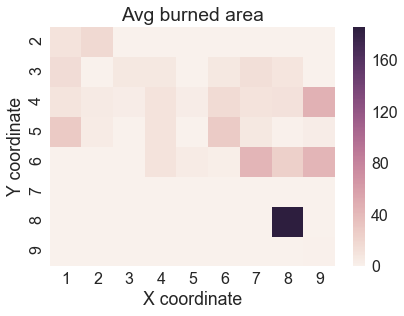

In [22]:
location_area_matrix = location_matrix.copy()

for X,Y in zip(avg_by_location_df.index.get_level_values(0),avg_by_location_df.index.get_level_values(1)):
    location_area_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'area'])
location_area_matrix = location_area_matrix.T
sns.set_context('paper',font_scale=2)
plt.figure()
sns.heatmap(location_area_matrix)
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Avg burned area')

# Feature engineering
While dataset is well organized already, feature engineering is still necessary. From EDA, `X`,`Y` and `month` seemed to carry some predictive power for burned `area`. Or, they may be just introducing undesirable redundancies over other low-level features and index values. By just analyzing the EDA results, the features with more predictive power can be statistically identified. In order to do that, `X`, `y` and `month` first need to be considered as nominal categorical data and converted to the appropriate format by one-hot-encoding technique. 

In [23]:
X_ohi = pd.get_dummies(df.X,prefix='X')
Y_ohi = pd.get_dummies(df.Y,prefix='Y')
Y_ohi.insert(5,'Y_7',0)
month_ohi = pd.get_dummies(df.month)
df = df.drop(['X','Y','month','day'],axis=1)
df = pd.concat([df,X_ohi,Y_ohi,month_ohi],axis=1)

In [26]:
print(df.columns)
print('New data has {} entries and {} features.'.format(df.shape[0],df.shape[1]))


Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area', 'X_1',
       'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'Y_2', 'Y_3',
       'Y_4', 'Y_5', 'Y_6', 'Y_7', 'Y_8', 'Y_9', 'jan', 'feb', 'mar', 'apr',
       'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
      dtype='object')
New data has 517 entries and 38 features.


In the new dataframe, `X`,`Y` and `month` are one-hot-encoded and `day` feature has been dropped. Now the data has 38 features in total.
# Initial ML fitting
The entire dataset only has 517 entires. Therefore, only 10% of it (~50) will be allocated as test set and others will be utlized to fit the model. The model will be selected via 5-fold CV evaluation.

Appropriate evaluation metrics for general regression problems include MAE and RMSE. There are similiar in nature, but RMSE is more sensitive to higher errors as the errors are squared before being averaged. Therefore, this project will use RMSE as a main metric.

#### Spliting into X and y sets
Test set is completely isolated from the training process. 

In [27]:
from sklearn.model_selection import train_test_split
X = df.drop('area',axis=1)
y = df.area

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=50)

#### Dummy regressor
Since the tatget variable, `area`, is highly skewed, the score of a dummy regressor, that always predict 0, would be a good reference for the actual model. 

In [28]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

dummy_constant = DummyRegressor(strategy='constant',constant=0).fit(X_train,y_train)
y_predicted_dummy = dummy_constant.predict(X_test)
print('RMSE of dummy regressor (test set) = {}'
      .format((mean_squared_error(y_test,y_predicted_dummy)**0.5).round(3)))

RMSE of dummy regressor (test set) = 17.097


Based on RMSE, the dummy regressor seems to be outperforming the model published by Cortez and Morais. While the metrics do not represent the entire performance of the model, high performance dummy models are typical in the imbalanced dataset just because the ocurrance of the event is extremely rare. A good model is the one that can predict these rarly occuring events from the zero baseline.

#### XGBooster Regressor and 5-fold CV
XGB regressor is a powerful and flexible model that has many tuning parameters. For this project, XGB regressor will be mainly used for fitting, while more attention is given to featuer engineering/transformation/selection processes to optimize the performance of the XGB regressor. The optimal parameters of the model will be searched through 5-fold CV and the model performance will be reported based on the test set. 

In [49]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV

grid_params = {'n_estimators':[3,10,30,100,300],'max_depth':[1,3,10,30],'learning_rate':[0.05,0.1,0.3,1]}
xgbr_grid_RMSE = GridSearchCV(XGBRegressor(),grid_params,cv=5,scoring='neg_mean_squared_error').fit(X_train,y_train)
print(xgbr_grid_RMSE.best_params_)
print('RMSE of xgbr (5-fold CV) = {:.3f}'.format(((-1*(xgbr_grid_RMSE.best_score_))**0.5)))

{'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 10}
RMSE of xgbr (5-fold CV) = 1.410


#### XGB regressor evalution on test set


In [22]:
xgbr_RMSE = XGBRegressor(learning_rate =0.3, max_depth=1, n_estimators=3).fit(X_train,y_train)
y_predicted_xgbr_RMSE = xgbr_RMSE.predict(X_test)
print('RMSE of xgbr (test set) = {}'
      .format((mean_squared_error(y_test,y_predicted_xgbr_RMSE)**0.5).round(3)))

RMSE of xgbr (test set) = 15.499


The RMSE of XGBR from 5-fold CV is quite similar to the one published by Cortez and Morais. When this model is evaluated on the test set, its RMSE is not really better than that of the dummy regressor. Also, the difference in CV score and test score is really large, indicating that the score is heavily affected by the difference of target variable distribution in train/test sets. This can be confirmed by comparing their skewness.

In [30]:
import scipy.stats as st
print('skewness of y_train is {:.3f}'.format(st.skew(y_train)))
print('skewness of y_test is {:.3f}'.format(st.skew(y_test)))

skewness of y_train is 12.244
skewness of y_test is 3.582


# Feature transformation
Even though `FFMC` is also strongly skewed, from EDA, it seems like it does not hold much predictive power due to its low variance. Similiarly, the skewness of `rain` may be ignored from the result of EDA.

The skewness of `area` can be easily dealt with a popular log transformation algorithm.

In [31]:
y_train = np.log(y_train+1)

In [32]:
print('skewness of y_train after log transformation is {:.3f}.'.format(st.skew(y_train)))

skewness of y_train after log transformation is 1.239.


After fitting, the predicted `area` can be inversely transformed by *np.expm1()* for evaluation on the test set.
# ML fitting with feature transformation
#### XGB regressor and 5-fold CV with feature transformation



In [38]:
grid_params = {'n_estimators':[3,10,30,100,300],'max_depth':[1,3,10,30],'learning_rate':[0.05,0.1,0.3,1]}
xgbr_grid_RMSE = GridSearchCV(XGBRegressor(),grid_params,cv=5,scoring='neg_mean_squared_error').fit(X_train,y_train)
print(xgbr_grid_RMSE.best_params_)
print('RMSE of xgbr (5-fold CV) = {:.3f}'.format(((-1*(xgbr_grid_RMSE.best_score_))**0.5)))

{'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 10}
RMSE of xgbr (5-fold CV) = 1.410


After feature transformation, their optimizing parameters have changed and
* the 5-fold CV RMSE score has improved from 67.244 to 1.410.

#### XGB regressor evalution on test set with feature transformation

In [39]:
xgbr_RMSE = XGBRegressor(learning_rate =0.3, max_depth=1, n_estimators=10).fit(X_train,y_train)
y_predicted_xgbr_RMSE = xgbr_RMSE.predict(X_test)
y_predicted_xgbr_RMSE = np.expm1(y_predicted_xgbr_RMSE) #inverse transformation
print('RMSE of xgbr (test set) = {}'
      .format((mean_squared_error(y_test,y_predicted_xgbr_RMSE)**0.5).round(3)))

RMSE of xgbr (test set) = 16.312


The RMSE of CV set showed remarkable improvement, but unfortunately, the RMSE of xgbr on test set got slightly worse than before even after the transformation.

#### Learning curve

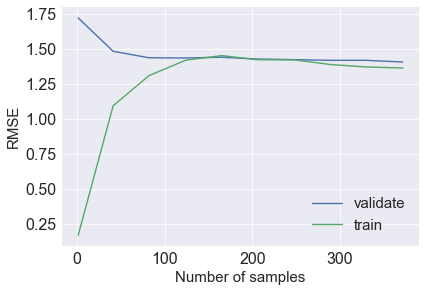

In [40]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(XGBRegressor(learning_rate =0.3, max_depth=1, n_estimators=10), X_train, y_train, cv=5, train_sizes =np.linspace(0.0001, 1.0, 10),scoring='neg_mean_squared_error')
plt.figure()
plt.plot(train_sizes,np.mean((valid_scores*-1)**0.5,axis=1),label='validate')
plt.plot(train_sizes,np.mean((train_scores*-1)**0.5,axis=1),label='train')
plt.xlabel('Number of samples',fontsize=15)
plt.ylabel('RMSE',fontsize=15)
plt.legend(fontsize=15)

The learning curve of CV looks okay as expected. This may indicate that the model is not overfitting, but the problem is still the distribution difference of the target variable between train and test sets. 

Therefore, this may not be entirely necessary, but some features may be removed to ahiceve a simpler model. This dataset is composed of many features that are related to each ohter. For example, index values are calculated from the low-level features. The redundancies can be removed by selecting a few features with the most predictive powers. 
# ML fitting with feature transformation and selection
#### Feature selection



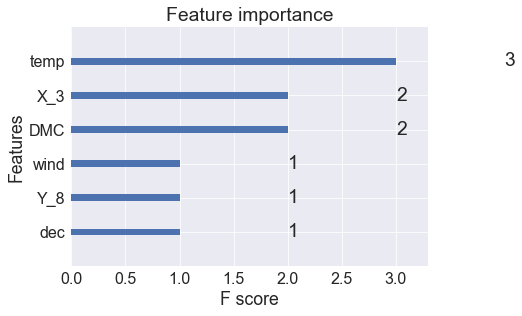

In [70]:
plot_importance(xgbr_RMSE,max_num_features=10)

Based on feature importance measure by XGB Regressor model, the six features are important while all others have no predictive power.
#### XGB regressor and 5-fold CV evalution with feature transformation and selection


In [71]:
X_train = X_train[['temp', 'X_3', 'DMC', 'wind','Y_8','dec']]
grid_params = {'n_estimators':[3,10,30,100,300],'max_depth':[1,3,10,30],'learning_rate':[0.05,0.1,0.3,1]}
xgbr_grid_RMSE = GridSearchCV(XGBRegressor(),grid_params,cv=5,scoring='neg_mean_squared_error').fit(X_train,y_train)
print(xgbr_grid_RMSE.best_params_)
print('RMSE of xgbr (5-fold CV) = {:.3f}'.format(((-1*(xgbr_grid_RMSE.best_score_))**0.5)))

{'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 10}
RMSE of xgbr (5-fold CV) = 1.404


#### XGB regressor evalution on test set with feature transformation and selection


In [72]:
X_test = X_test[['temp', 'X_3', 'DMC', 'wind','Y_8','dec']]
xgbr_RMSE = XGBRegressor(learning_rate =0.3, max_depth=1, n_estimators=10).fit(X_train,y_train)
y_predicted_xgbr_RMSE = xgbr_RMSE.predict(X_test)
y_predicted_xgbr_RMSE = np.expm1(y_predicted_xgbr_RMSE)

print('RMSE of xgbr (test set) = {}'
      .format((mean_squared_error(y_test,y_predicted_xgbr_RMSE)**0.5).round(3)))

RMSE of xgbr (test set) = 16.312


RMSE still has no change as expected, saying that this is not a over-fitting issue.

***Unfortunately, this model is still performing really bad. (only marginally better than the dummy regressor*** If a few cases of actual y_test and y_predicted are compared (below), it can be seen that the model is almost always predicting very low values for burned `area`.

Since the target variable is strongly skewed towards 0, predicting low values gives relatively reasonable RMSE score, but this is not acceptable. 

It seems like the effect of imbalanced target variable is still overwhelming. One apprach that can be considered is an oversampling technique.   

In [75]:
ser = pd.Series(y_predicted_xgbr_RMSE,index=y_test.index,name='predicted_area')
pd.concat([y_test,ser],axis=1).head(20)

,area,predicted_area
463,5.39,2.616916
418,2.44,2.926862
391,30.18,1.550778
370,11.06,2.400699
166,2.29,1.550778
453,0.00,2.400699
384,12.18,2.400699
115,0.00,1.093937
23,0.00,1.756989
408,7.80,2.400699


# Oversampling

#### Arbitrarily adding duplicates of samples (with burned area > 10,  >50 and >100) to the training set
While the test set is totally isolated for the later evaluation, duplicates of the samples that have medium/large burned area can be **added to the training set** for oversampling. 

In [173]:
df_oversampling = df[['temp', 'X_3', 'DMC', 'wind','Y_8','dec','area']]

train,test = train_test_split(df_oversampling,test_size=0.05,random_state = 300)
copy_10 = train[train.area>10]
copy_50 = train[train.area>50]
copy_100 = train[train.area>100]
bulk = pd.concat([copy_10,copy_50,copy_50,copy_50,copy_100,copy_100])
train = pd.concat([train,bulk]).sample(frac=1).reset_index(drop=True)

X_train = train.drop('area',axis=1)
y_train = train.area
y_train = np.log(y_train+1)

X_test = test.drop('area',axis=1)
y_test = test.area


In [174]:
grid_params = {'n_estimators':[3,10,30,100,300],'max_depth':[1,3,10,30],'learning_rate':[0.05,0.1,0.3,1]}
xgbr_grid_RMSE = GridSearchCV(XGBRegressor(),grid_params,cv=5,scoring='neg_mean_squared_error').fit(X_train,y_train)
print(xgbr_grid_RMSE.best_params_)
print('RMSE of xgbr (5-fold CV) = {:.3f}'.format(((-1*(xgbr_grid_RMSE.best_score_))**0.5)))

{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 10}
RMSE of xgbr (5-fold CV) = 1.212


#### XGB regressor evalution on test set with feature transformation, selection and oversampling


In [178]:
xgbr_RMSE = XGBRegressor(learning_rate=0.3, max_depth=10, n_estimators=10).fit(X_train,y_train)
y_predicted_xgbr_RMSE = xgbr_RMSE.predict(X_test)
y_predicted_xgbr_RMSE = np.expm1(y_predicted_xgbr_RMSE)
print('RMSE of xgbr (test set) = {}'
      .format((mean_squared_error(y_test,y_predicted_xgbr_RMSE)**0.5).round(3)))

RMSE of xgbr (test set) = 3.236


The RMSE metrics on the test set got much better than before **(from 16.312 to 3.236)**. However, **the model actually improved much more than the metrics represnted**. 

By comparing a few sets of the true `area` of the test set and the `predicted area`, it can be seen that the model is "trying" to predict the burned `area` based on `temp`, `X_3`, `DMC`, `wind`,`Y_8`,`dec` and `area`. The model tends to *overestimate* in general, but it is showing relatively good prediction capability for non-zero `area`.

In [179]:
ser = pd.Series(y_predicted_xgbr_RMSE,index=y_test.index,name='predicted_area')
pd.concat([y_test,ser],axis=1).head(20)


,area,predicted_area
162,1.94,0.186111
18,0.00,0.885263
182,6.38,0.905110
143,0.71,3.711852
29,0.00,4.837190
254,10.34,9.746708
34,0.00,1.590981
477,7.36,1.205539
275,5.38,3.181273
114,0.00,-0.016933


# Conclusion
As this wraps up the project, it should be acknowledged that this was rather a difficult regression problem. The target variable was severaly imbalanced towards 0 and features had relatively low predictive powers in general. 

Many different approachs were taken including feature transformation and selection. While it helped lowering the actual metrics (MAE and RMSE), the actual prediction results were rather disappointing. The last approach tried was oversampling. This technique was used to arbitrarily increase the frequency of less-represented target varaibles. Even though this was done very roughly, it showed dramatic improvement in the model performance. 

For further optimization, some other techniques like undersampling can be considered or other training models may be investigated.   